<a href="https://colab.research.google.com/github/elenadanchenkomn/analisys_python/blob/main/%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B4%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B0_%C2%AB%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D1%82%D0%B8%D0%BA_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%C2%BB%22_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Импорт библиотек

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

#### Подключение к Базе Данных

In [ ]:
db_config = {'user': 'mentor',
             'pwd': 'm06uz3.tMQ017y8n',
             'host': '185.86.147.205',
             'port': 5432,
             'db': 'db_mentor'}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])
engine = create_engine(connection_string)

In [ ]:
def select(sql):
    return pd.io.sql.read_sql(sql, con = engine)

Проверим наших пользователей на уникальность 

In [ ]:
sql = '''
SELECT  count(*) all_id,
        count(DISTINCT user_id) as all_unique_id
FROM    users
                '''

select(sql)

,all_id,all_unique_id
0,3132,3132


Посчитаем, сколько у нас зарегистрированных менторов и менти на платформе

In [ ]:
sql = '''
SELECT  role,
        count(user_id) as user_quantity
FROM    users
GROUP BY 
        role
                '''

select(sql)

,role,user_quantity
0,mentee,2509
1,mentor,623


Проверим сессии на уникальность id и посчитаем, сколько было проведено сессий

In [ ]:
sql = '''
SELECT  count(*) as all_id,
        count(DISTINCT session_id) as all_unique_id
FROM    sessions
                '''

select(sql)

,all_id,all_unique_id
0,6524,6524


Убедимся, что все менти и менторы, участвовавшие в сессиях у нас есть в таблице пользователей

In [ ]:
sql = '''
SELECT  count(DISTINCT mentee_id) as mentee_quantity
FROM    sessions s 
WHERE   NOT EXISTS (SELECT user_id FROM users WHERE mentee_id = user_id)
                '''

print('Количество менти, которых нет в users: ', select(sql)['mentee_quantity'].loc[select(sql).index[0]])

sql = '''
SELECT  count(DISTINCT mentor_id) as mentor_quantity
FROM    sessions s 
WHERE   NOT EXISTS (SELECT user_id FROM users WHERE mentor_id  = user_id)
                '''

print('Количество менторов, которых нет в users: ', select(sql)['mentor_quantity'].loc[select(sql).index[0]])

Количество менти, которых нет в users:  0
Количество менторов, которых нет в users:  0


Все пользователи у нас есть

Проведя небольшую исследовательскую работу с данными, мы выяснили что менторы не могут быть менти и наоборот, что все id уникальны. 


Какое количество менторов и менти взаимодействуют каждый месяц на нашей платформе? Как меняется этот показатель из месяца в месяц?

In [ ]:
sql = '''
SELECT  date_trunc('month', session_date_time) :: date as session_month, 
        count(DISTINCT mentee_id) as mentee_cnt, 
        count(DISTINCT mentor_id) as mentor_cnt
FROM    sessions s 
GROUP BY 
        session_month
ORDER BY 
        session_month
                '''

select(sql)

,session_month,mentee_cnt,mentor_cnt
0,2021-02-01,3,3
1,2021-03-01,3,3
2,2021-04-01,7,7
3,2021-05-01,19,18
4,2021-06-01,27,24
5,2021-07-01,35,37
6,2021-08-01,56,53
7,2021-09-01,70,63
8,2021-10-01,89,86
9,2021-11-01,114,102


Данные имеют четкий восходящий тренд: количество пользователей приростает от месяца к месяцу.Но в сентябре количество менти и менторов принимающих участие в сессиях меньше, чем в августе. Проверим полноту данных за сентябрь:

In [ ]:
sql = '''
SELECT  max(session_date_time) as max_date
FROM    sessions s 
                '''

select(sql)

,max_date
0,2022-09-15 23:47:25


Снижение в сентябре не является ухудшением, потому что месяц еще не завершился и данные не полные. 


Сколько на платформе менторов и менти, которые еще не приняли участие ни в одной встрече?

In [ ]:
sql = '''
SELECT  count(user_id) FILTER (WHERE "role" = 'mentee') as mentee_quantity
FROM    users u 
WHERE   NOT EXISTS (SELECT mentee_id FROM sessions WHERE mentee_id = user_id)
                '''

print('Количество менти, которые не приняли участие ни в одной сессии: ', select(sql)['mentee_quantity'].loc[select(sql).index[0]])

sql = '''
SELECT  count(user_id) FILTER (WHERE "role" = 'mentor') as mentor_quantity
FROM    users u 
WHERE   NOT EXISTS (SELECT mentor_id FROM sessions WHERE mentor_id = user_id)
                '''

print('Количество менторов, которые не приняли участие ни в одной сессии: ', select(sql)['mentor_quantity'].loc[select(sql).index[0]])

Количество менти, которые не приняли участие ни в одной сессии:  662
Количество менторов, которые не приняли участие ни в одной сессии:  0


Из сопутсвующих данных есть только дата регистрации пользователя и регион. Сгруппируем пользователей по этим признакам. Нет менторов, которые не принимают участие в сессиях, поэтому рассмотрим только менти. 

In [ ]:
# Менти (дата регистрации)
sql = '''
SELECT  date_trunc('month', reg_date) :: date as created_month,
        count(user_id) FILTER (WHERE "role" = 'mentee') as mentee_quantity
FROM    users u 
WHERE   NOT EXISTS (SELECT mentee_id FROM sessions WHERE mentee_id = user_id)
GROUP BY    
        created_month
ORDER BY 
        created_month
                '''

select(sql)

,created_month,mentee_quantity
0,2021-01-01,29
1,2021-02-01,19
2,2021-03-01,38
3,2021-04-01,25
4,2021-05-01,30
5,2021-06-01,36
6,2021-07-01,47
7,2021-08-01,33
8,2021-09-01,32
9,2021-10-01,30


In [ ]:
# Менти (регионы)
sql = '''
SELECT  r."name" as region_name,
        count(id) FILTER (WHERE "role" = 'mentee') as person_quantity
FROM    users u 
        LEFT JOIN region r 
            ON u.region_id = r.id 
WHERE   NOT EXISTS (SELECT mentee_id FROM sessions WHERE mentee_id = user_id)
GROUP BY    
        r."name"
ORDER BY 
        person_quantity DESC 
                '''

select(sql).head(5)

,region_name,person_quantity
0,г Москва,272
1,Ростовская обл,71
2,г Санкт-Петербург,70
3,Ленинградская обл,49
4,Краснодарский край,49


Может показаться, что пользователи из Москвы являются тем сегментом, который не пользуется сервисом. Однако, важнее посмотреть какая доля пользователей из этого региона не приходит на занятия. Рассчитаем этот показатель: 

In [ ]:
# Менти (регионы, доли)
sql = '''
WITH data_preparation AS 
(
    SELECT  u.user_id,
            r."name" as region_name,
            EXISTS (
                        SELECT  1 
                        FROM    sessions s  
                        WHERE   u.user_id = s.mentee_id
                    ) has_session
    FROM    users u 
            LEFT JOIN region r 
                ON u.region_id = r.id 
    WHERE   u."role" = 'mentee'
) 

SELECT  region_name, 
        count(user_id) as all_user, 
        round(count(user_id) FILTER (WHERE has_session IS FALSE) :: NUMERIC / count(user_id), 2) as user_without_session_percent 
FROM    data_preparation
GROUP BY 
        region_name
ORDER BY 
        all_user DESC, 
        user_without_session_percent DESC 
                '''

select(sql)

,region_name,all_user,user_without_session_percent
0,г Москва,1016,0.27
1,г Санкт-Петербург,254,0.28
2,Ростовская обл,243,0.29
3,Краснодарский край,200,0.25
4,Ленинградская обл,196,0.25
5,Московская обл,157,0.27
6,Другое,130,0.22
7,Нижегородская обл,121,0.28
8,Новосибирская обл,79,0.24
9,Омская обл,45,0.33


In [ ]:
select(sql)['user_without_session_percent'].describe()

count    15.000000
mean      0.284000
std       0.101896
min       0.110000
25%       0.245000
50%       0.270000
75%       0.290000
max       0.500000
Name: user_without_session_percent, dtype: float64

Несмотря на большое количество пользователей из Москвы, которые не участвовали ни в одной сессии, доля от всех пользователей из этого региона близка к медианному значению (Q2). Более 50% от всех регионов имеют большее значение данной метрики. Нельзя однозначно заявить о влиянии региона на прохождение сессий. 

По данным нельзя сделать вывод о причинах отсутствия сессий у пользователей. 


Сколько у каждого ментора в среднем успешных сессий в неделю по месяцам? Как меняется частота встреч в неделю от месяца к месяцу?

In [ ]:
# Сколько у каждого ментора в среднем сессий в неделю по месяцам
sql = '''
WITH month_week_table AS 
(
    SELECT  mentor_id,
            date_trunc('month', session_date_time) :: date session_month,
            EXTRACT(month from session_date_time) month_n,
            EXTRACT(week from session_date_time) week_n, 
            count(session_id) session_per_week
    FROM    sessions s 
    WHERE   session_status = 'finished'
    GROUP BY 
            mentor_id, 
            session_month, 
            month_n, 
            week_n
)

SELECT  mentor_id, 
        session_month :: date,
        month_n :: int, 
        avg(session_per_week) :: int avg_session_per_week
FROM    month_week_table
GROUP BY 
        mentor_id, 
        session_month,
        month_n
ORDER BY 
        avg_session_per_week DESC 
                '''

select(sql).sample(5)

,mentor_id,session_month,month_n,avg_session_per_week
2059,2123,2022-07-01,7,1
1477,1299,2022-05-01,5,1
354,325,2022-09-01,9,2
2652,3407,2022-02-01,2,1
1909,4503,2022-07-01,7,1


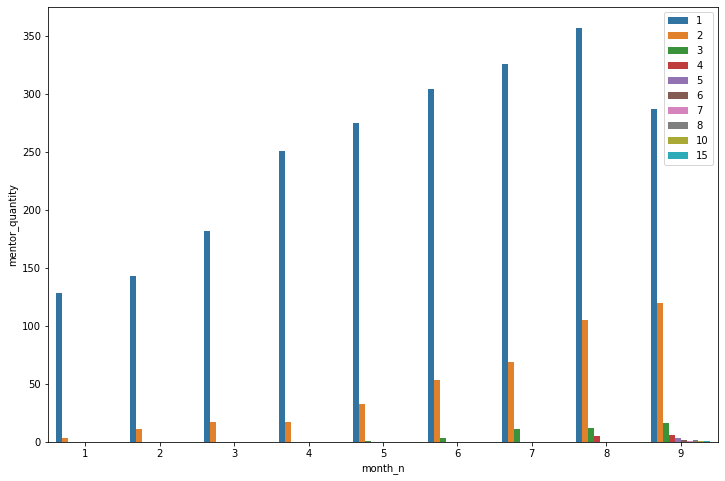

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=(select(sql).astype({'session_month' : 'datetime64[ns]'})
                  .query("session_month >= '2022-01-01'")
                  .groupby(['month_n', 'avg_session_per_week'])
                  .agg(mentor_quantity = ('mentor_id', 'nunique'))
                  .reset_index()), 
            x="month_n", y="mentor_quantity", 
            hue="avg_session_per_week")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Как видно из нашей визуализации с мая часть менторов стали проводить в среднем более 2 сессий в неделю, а для дальнейших месяцев среднее количество сессий в неделю еще увеличилось и в сентябре у нас есть менторы, которые провели 5 и более сессий. 

In [ ]:
# ТОП 5 менторов по количеству сессий за последний полный месяц

sql = '''
WITH session_per_mentor AS 
(
    SELECT  mentor_id,  
            count(session_id) as session_quantity
    FROM    sessions s
    WHERE   session_date_time :: date BETWEEN '2022-08-01' AND '2022-08-31'
    GROUP BY 
            mentor_id 
),
session_quantity_numeration AS
(
    SELECT  mentor_id, 
            session_quantity, 
            DENSE_RANK () OVER (ORDER BY session_quantity DESC) as dr
    FROM    session_per_mentor
) 

SELECT  mentor_id
FROM    session_quantity_numeration
WHERE   dr <= 5
                '''

select(sql)

,mentor_id
0,4256
1,2192
2,1903
3,1552
4,4798
5,3855
6,328
7,4015
8,1357




Сколько времени в среднем проходит между менторскими встречами у одного менти? ментора?

In [ ]:
sql = '''
WITH next_session_dt_preparation AS 
(
    SELECT  mentor_id, 
            session_date_time, 
            LEAD (session_date_time) OVER (PARTITION BY mentor_id ORDER BY session_date_time) as next_session_dt, 
            ROW_NUMBER () OVER (PARTITION BY mentor_id ORDER BY session_date_time) rn
    FROM    sessions s 
), 
day_diff_table AS 
(
    SELECT  *,
            date_part('day', next_session_dt - session_date_time) as day_diff
    FROM    next_session_dt_preparation
    WHERE   rn = 1
) 

SELECT  mentor_id,
        day_diff
FROM    day_diff_table
                '''

select(sql)['day_diff'].describe()

count    623.000000
mean      46.290530
std       57.030967
min        0.000000
25%        7.000000
50%       24.000000
75%       62.000000
max      325.000000
Name: day_diff, dtype: float64

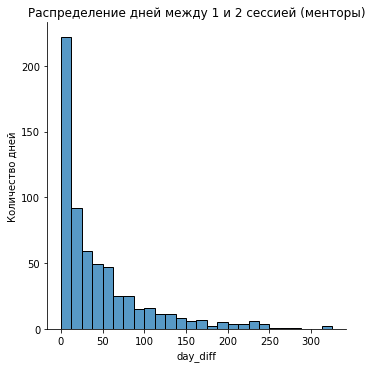

In [ ]:
sns.displot(data=select(sql), x="day_diff")
plt.title('Распределение дней между 1 и 2 сессией (менторы)')
plt.ylabel('Количество дней')
plt.show()

In [ ]:
sql = '''
WITH next_session_dt_preparation AS 
(
    SELECT  mentee_id, 
            session_date_time, 
            LEAD (session_date_time) OVER (PARTITION BY mentee_id ORDER BY session_date_time) as next_session_dt, 
            ROW_NUMBER () OVER (PARTITION BY mentee_id ORDER BY session_date_time) rn
    FROM    sessions s 
), 
day_diff_table AS 
(
    SELECT  *,
            date_part('day', next_session_dt - session_date_time) as day_diff
    FROM    next_session_dt_preparation
    WHERE   rn = 1
) 

SELECT  mentee_id,
        day_diff
FROM    day_diff_table
                '''

select(sql)['day_diff'].describe()

count    1497.000000
mean       74.050768
std        82.108364
min         0.000000
25%        15.000000
50%        45.000000
75%       106.000000
max       509.000000
Name: day_diff, dtype: float64

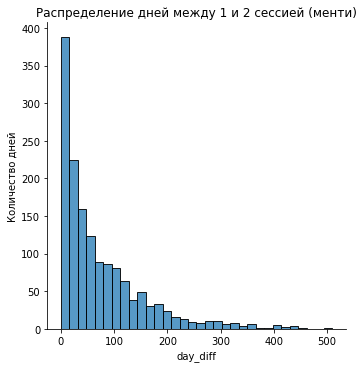

In [ ]:
sns.displot(data=select(sql), x="day_diff")
plt.title('Распределение дней между 1 и 2 сессией (менти)')
plt.ylabel('Количество дней')
plt.show()

Распределения имеют длинные хвосты, но несмотря на это 50% пользователей, которые приняли участие во второй сессии сделали это в течение месяца (для менторов) и в течение полутора месяцев для менти. 


Сколько сессий по каждому направлению менторства в месяц обычно отменяется? Как меняется доля отмененных сессий помесячно?

Рассчитаем долю отмен от всех назначенных сессий. 

In [ ]:
sql = '''
SELECT  date_trunc('month', session_date_time) :: date session_month,
        count(session_id) all_session, 
        round(count(session_id) FILTER (WHERE session_status = 'canceled') :: numeric/ count(session_id), 2) canceled_percent
FROM    sessions  
WHERE   session_date_time :: date < '2022-09-01'
GROUP BY 
        session_month
ORDER BY 
        session_month
                '''

select(sql)

,session_month,all_session,canceled_percent
0,2021-02-01,3,0.00
1,2021-03-01,3,0.00
2,2021-04-01,7,0.29
3,2021-05-01,19,0.21
4,2021-06-01,27,0.15
5,2021-07-01,37,0.19
6,2021-08-01,59,0.10
7,2021-09-01,71,0.13
8,2021-10-01,101,0.11
9,2021-11-01,119,0.20


In [ ]:
select(sql)['canceled_percent'].describe()

count    19.000000
mean      0.151053
std       0.067321
min       0.000000
25%       0.130000
50%       0.160000
75%       0.185000
max       0.290000
Name: canceled_percent, dtype: float64

Медианное и среднее значение досточно близки. Это значит, что наша метрика (доля отмен) не склонна к выбросам, а ее нормальное значение лежит в диапазоне от 6 до 21 процентов. 


Определите, в какой день недели последнего полного месяца прошло больше всего встреч. В результате выведите названия сферы и необходимые данные.

In [ ]:
sql = '''
WITH session_per_week_day AS 
(
    SELECT  d."name" domain_name, 
            to_char(s.session_date_time, 'dy') week_day, 
            count(session_id) session_quantity
    FROM    sessions s
            INNER JOIN "domain" d 
                ON s.mentor_domain_id = d.id  
    WHERE   session_date_time :: date BETWEEN '2022-08-01' AND '2022-08-31'
    GROUP BY 
            domain_name, 
            week_day
),
dense_rank_table AS 
(
    SELECT  *, 
            DENSE_RANK() OVER (PARTITION BY domain_name ORDER BY session_quantity DESC) dr
    FROM    session_per_week_day
)

SELECT  domain_name, 
        week_day, 
        session_quantity
FROM    dense_rank_table
WHERE   dr = 1
                '''

select(sql)

,domain_name,week_day,session_quantity
0,AB тестирование,tue,27
1,DS,wed,40
2,Python для аналитики данных,wed,40
3,SQL,mon,47
4,Визуализация данных,wed,29
5,Машинное обучение,tue,42
6,Продуктовая аналитика,sun,35


Самый загруженный день — среда. 


Спрогнозируйте, сколько новых менторов нужно найти, если в следующем месяце количество активных менти увеличится на 500 человек. Учитывайте, что занятость новых менторов, будет такой же, как у текущих.

Данных для полноценного прогнозироания у нас недостаточно. Попробуем спрогнозировать необходимое количество менторов с помощью модели линейной регрессии. 

Рассчитаем необходимые данные и спрогнозируем ожидаемое значение:

In [ ]:
sql = '''
SELECT  date_trunc('month', session_date_time) :: date, 
        count(DISTINCT  mentor_id) mentor_cnt, 
        count(DISTINCT mentee_id) mentee_cnt
FROM    sessions s 
GROUP BY 
        1
ORDER BY 
        1
                '''

select(sql).tail(3)

,date_trunc,mentor_cnt,mentee_cnt
17,2022-07-01,446,684
18,2022-08-01,509,883
19,2022-09-01,469,757


In [ ]:
# Подсчет коэффициента линейной регрессии и прогнозирование

x = select(sql)['mentee_cnt'].to_numpy().reshape((-1, 1))
y = select(sql)['mentor_cnt'].to_numpy()

model = LinearRegression().fit(x, y)

x_new = np.append(x, x[-1] + 500).reshape((-1, 1))
y_new = model.predict(x_new)

print("Потребуется менторов: ", round(y_new[-1], 0))
print("Потребуется найти менторов: ", round(y_new[-1], 0) - round(y[-1], 0))

Потребуется менторов:  792.0
Потребуется найти менторов:  323.0
